# Planar Data Classification with a Hidden Layer

I basically followed https://github.com/Kulbear 's work on Andrew Ng's Deep Learning Specialization C1W2 homework assignment with some modification


### We will implement neural network with a single hidden layer from scratch 

- Implement a 2-class classification neural network with a single hidden layer
- Use units with a non-linear activation function, such as tanh
- Compute the cross entropy loss
- Implement forward and backward propagation

## 1. Importing the libraries and setting up the enviornments

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
import sklearn.datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

%matplotlib inline

In [2]:
# setting up enviornment
%matplotlib inline

np.random.seed(1)

## 2. Preparing the dataset for classification

In [3]:
def prepare_planar_dataset():
  m = 400 # number of training examples
  N = 200 # number of points per class
  D = 2 # dimensionality 
  X = np.zeros(shape=(m, D)) 
  Y = np.zeros(shape=(m, 1), dtype=np.uint8)
  a = 4 # maximum ray of the flower

  for j in range(2):
    ix = np.arange( N*j, N*(j+1))
    t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
    r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    Y[ix] = j
        
  X = X.T
  Y = Y.T

  return X, Y

In [4]:
X, Y = prepare_planar_dataset()
X.shape, Y.shape

((2, 400), (1, 400))

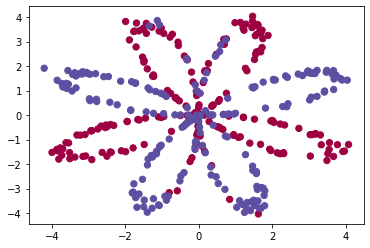

In [5]:
# visualize the dataset
# X : (nx, m)

plt.scatter(X[0, :], X[1, :], s=40, c=Y[0, :], cmap=plt.cm.Spectral)

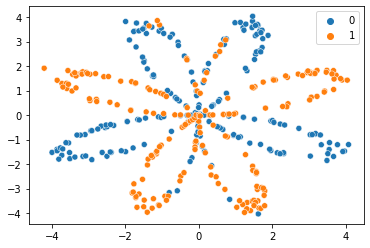

In [6]:
sns.scatterplot(data=X, x= X[0, :], y=X[1, :], hue=Y[0, :], cmap='Spectral')

## 3. Logistic Regression

In [7]:
classifier = LogisticRegression()
classifier.fit(X.T, Y.T)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [8]:
# X = (nx, m)
def plot_decision_boundary(model, X, Y):
  x1_min, x1_max = X[0, :].min()- 1, X[0, :].max() + 1 
  x2_min, x2_max = X[1, :].min()- 1, X[1, :].max() + 1
  step = 0.01 
  x1_grid, x2_grid = np.meshgrid(np.arange(x1_min, x1_max, step), np.arange(x2_min, x2_max, step))
  Y_pred = model(np.c_[x1_grid.ravel(), x2_grid.ravel()])
  Y_pred = Y_pred.reshape(x1_grid.shape)
  plt.contourf(x1_grid, x2_grid, Y_pred, cmap=plt.cm.Spectral)
  plt.scatter(X[0, :], X[1, :], s=40, c=Y[0, :], cmap=plt.cm.Spectral)

0.47

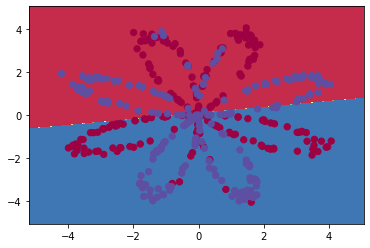

In [9]:
plot_decision_boundary(lambda x: classifier.predict(x), X, Y)

Y_pred_LR = classifier.predict(X.T)
accuracy_score(Y.T, Y_pred_LR)

## 4. Neural Network with a single Hidden Layer

General Methodology to build Neural Network 
1. define NN architecure
2. initialize parameters
3. Loop
  - compute output of the NN (forward propagation)
  - compute cost 
  - compute gradients (backward propagation)
  - update parameters (gradient descent)

### 4.1 Define NN architeture
Define layer sizes
- n_x : size of input layer 
- n_h : size of units of hidden layer
- n_y : size of output layer

In [10]:
def layer_sizes(X, Y, n_h=4):
  n_x = X.shape[0]
  n_h = n_h
  n_y = Y.shape[0]
  #print(n_h)
  return n_x, n_h, n_y

### 4.2 Initialize parameters
 
Initialize the following parameters
- W1
- b1
- W2
- b2

In [11]:
def initialize_parameters(n_x, n_h, n_y):
  W1 = np.random.randn(n_h, n_x)
  b1 = np.zeros((n_h, 1))
  W2 = np.random.randn(n_y, n_h)
  b2 = np.zeros((n_y, 1))

  parameters = {
      'W1': W1,
      'b1': b1,
      'W2': W2,
      'b2': b2
  }

  return parameters

### 4.3 Define the Loop

1. compute output of the NN (forward propagation)
2. compute cost
3. compute gradients (backward propagation)
4. update parameters (gradient descent)


In [12]:
def sigmoid(Z):
  return 1 / (1 + np.exp(-Z))

In [13]:
def forward_propagation(X, parameters):
  
  W1 = parameters['W1'] 
  b1 = parameters['b1']
  W2 = parameters['W2']
  b2 = parameters['b2']
  
  Z1 = np.dot(W1, X) + b1
  A1 = np.tanh(Z1)
  Z2 = np.dot(W2, A1) + b2
  A2 = sigmoid(Z2)

  cache = {
      'Z1' : Z1,
      'A1' : A1,
      'Z2' : Z2,
      'A2' : A2
  }

  return A2, cache

In [14]:
def compute_cost(A2, Y):

  m = Y.shape[1]
  log_likelyhood = np.multiply(Y, np.log(A2)) + np.multiply(1- Y, np.log(1 - A2))
  cost = (-1 / m ) * np.sum(log_likelyhood)
  cost = np.squeeze(cost) # make sure the dimension is correct 
  return cost

In [15]:
def back_propagation( parameters, cache, X, Y):

  m = X.shape[1]
  Z1 = cache['Z1']
  A1 = cache['A1']
  Z2 = cache['Z2']
  A2 = cache['A2']

  W1 = parameters['W1'] 
  b1 = parameters['b1']
  W2 = parameters['W2']
  b2 = parameters['b2']

  dZ2 = A2 - Y
  dW2 = (1/m) * np.dot(dZ2, A1.T)
  db2 = (1/m) * np.sum(dZ2, axis=1, keepdims=True)

  dZ1 = np.dot(W2.T, dZ2) *  (1 - np.power(A1, 2))
  dW1 = (1/m) * np.dot(dZ1, X.T)
  db1 = (1/m) * np.sum(dZ1, axis=1, keepdims=True)

  grads = {
      'dW1' : dW1,
      'db1' : db1,
      'dW2' : dW2,
      'db2' : db2
  }

  return grads

In [16]:
def update_parameters(grads, parameters, learning_rate=1.2):
  
  dW1 = grads['dW1']
  db1 = grads['db1']
  dW2 = grads['dW2']
  db2 = grads['db2']

  W1 = parameters['W1']
  b1 = parameters['b1']
  W2 = parameters['W2']
  b2 = parameters['b2']  

  W1 = W1 - learning_rate * dW1
  b1 = b1 - learning_rate * db1
  W2 = W2 - learning_rate * dW2
  b2 = b2 - learning_rate * db2

  parameters = {
      'W1': W1,
      'b1': b1,
      'W2': W2,
      'b2': b2
  }
  return parameters

### 4.4 Integrate 4.1, 4.2, 4.3 in nn_model

In [17]:
def nn_model(X, Y, n_h, num_iterations=10000, print_cost=False):
  
  np.random.seed(3)

  n_x, n_h, n_y = layer_sizes(X, Y, n_h)
  parameters = initialize_parameters(n_x, n_h, n_y)

  for i in range(0, num_iterations):
    A2, cache = forward_propagation(X, parameters)
    cost = compute_cost(A2, Y)
    grads = back_propagation( parameters, cache, X, Y)
    parameters = update_parameters(grads, parameters)

    if print_cost and i%1000 ==0:
      print('Cost after iteration %i: %f'% (i, cost))
  return parameters

### 4.5 predict

In [18]:
def predict(parameters, X):
  
  A2, cache = forward_propagation(X, parameters)
  predictions = np.round(A2)

  return predictions


Cost after iteration 0: 0.770532
Cost after iteration 1000: 0.262819
Cost after iteration 2000: 0.249001
Cost after iteration 3000: 0.242097
Cost after iteration 4000: 0.237475
Cost after iteration 5000: 0.234112
Cost after iteration 6000: 0.231629
Cost after iteration 7000: 0.229774
Cost after iteration 8000: 0.228365
Cost after iteration 9000: 0.227274


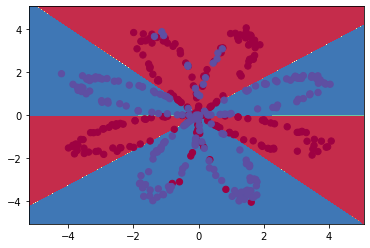

In [19]:
parameters = nn_model(X, Y, n_h = 4, num_iterations=10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)


In [20]:
predictions = predict(parameters, X)

accuracy_score(Y[0, :], predictions[0, :])

0.91

### 4.6 Tuning Hidden Layer Size

accuracy for 1 hidden units 0.6625 %
accuracy for 2 hidden units 0.6475 %
accuracy for 3 hidden units 0.9075 %
accuracy for 4 hidden units 0.9075 %
accuracy for 5 hidden units 0.9 %
accuracy for 20 hidden units 0.9075 %
accuracy for 50 hidden units 0.915 %


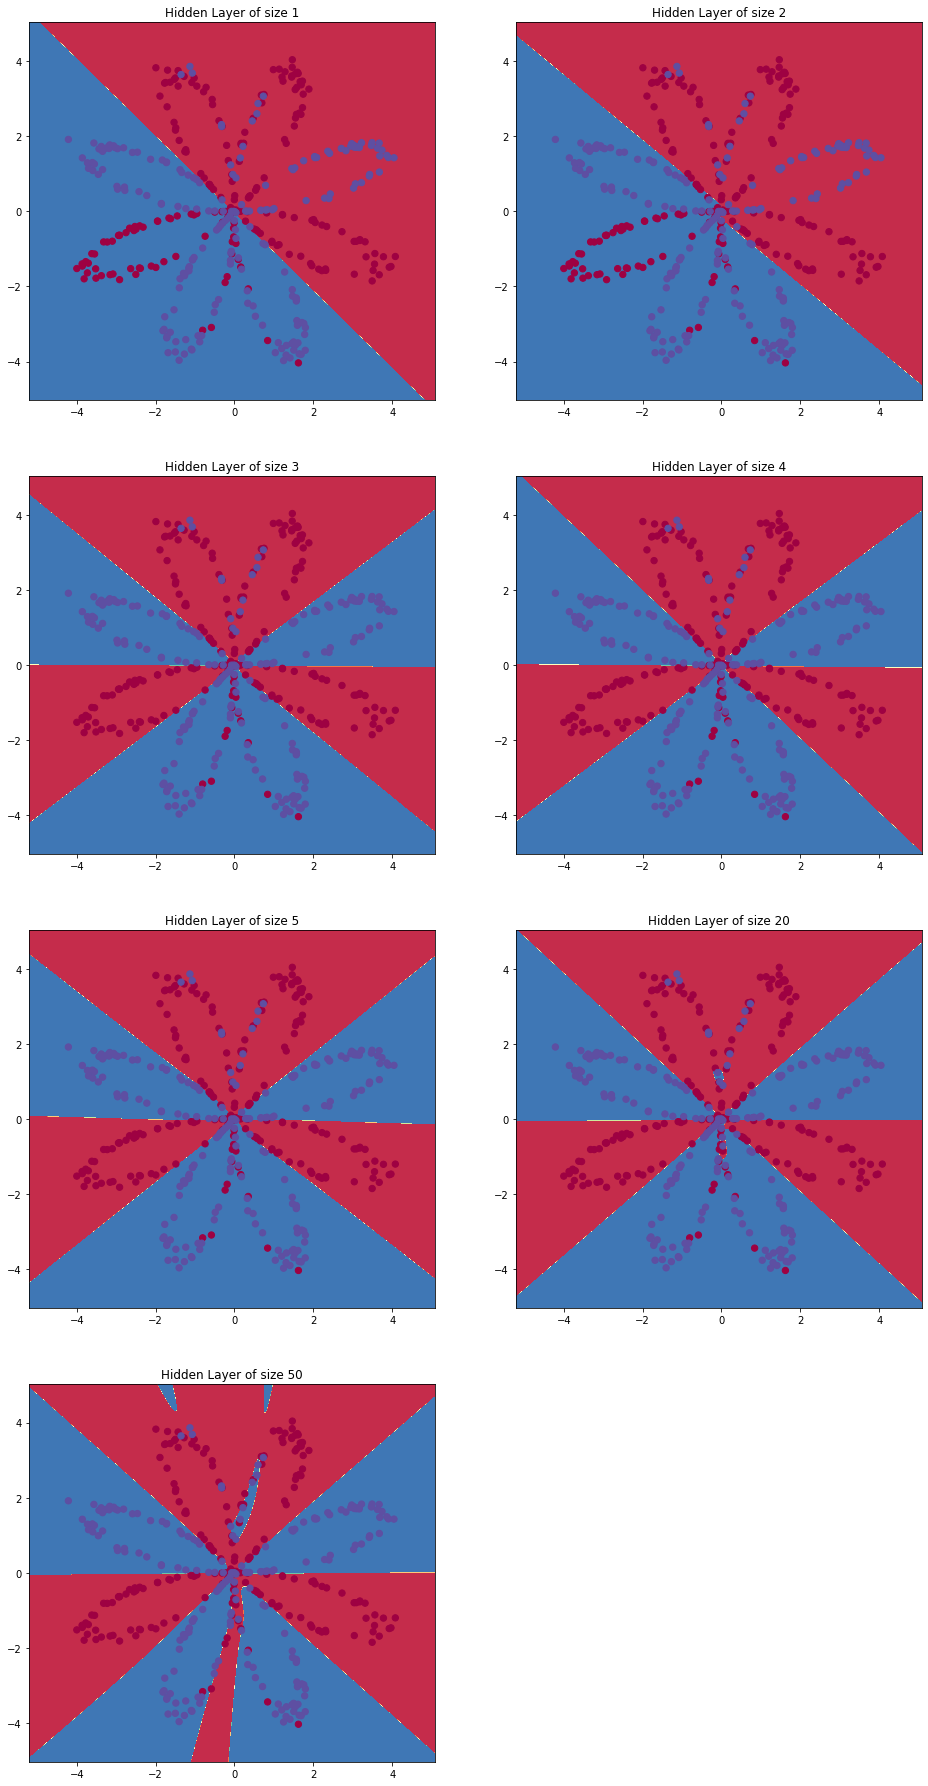

In [21]:
plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50]

for i, n_h in enumerate(hidden_layer_sizes):
  plt.subplot(4, 2, i+1)
  plt.title('Hidden Layer of size %d' % n_h)
  parameters = nn_model(X, Y, n_h, num_iterations = 5000)
  plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
  predictions = predict(parameters, X)
  accuracy = accuracy_score(Y[0, :], predictions[0, :])
  #print(accuracy)
  print('accuracy for {} hidden units {} %'.format(n_h, accuracy))
